# Logs analysis - Machine Learning

In [111]:
# Data wrangling - Spark
from pyspark.sql.functions import sha2, udf, col, split, monotonically_increasing_id, regexp_extract
import pyspark.sql.functions as F
from pyspark.sql.types import *

# Machine Learning - ML
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler


# Parsing  user agents
import user_agents

# Sys
import os
from pathlib import Path
import re

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
ROOT_PATH = Path("..")
file_path = ROOT_PATH /"data"/"processed"/"labeled_df"

In [5]:
df = spark.read.parquet(file_path.__str__())

In [64]:
df.printSchema()

root
 |-- ip_address: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status_code: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- datetime_utc: timestamp (nullable = true)
 |-- request_method: string (nullable = true)
 |-- request_uri: string (nullable = true)
 |-- http_version: string (nullable = true)
 |-- request_file: string (nullable = true)
 |-- browser_family: string (nullable = true)
 |-- browser_version_string: string (nullable = true)
 |-- os_family: string (nullable = true)
 |-- os_version_string: string (nullable = true)
 |-- device_family: string (nullable = true)
 |-- device_brand: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- is_mobile: boolean (nullable = true)
 |-- is_tablet: boolean (nullable = true)
 |-- is_touch_capable: boolean (nullable = true)
 |-- is_pc: boolean (nullable = true)
 |-- is_ua_bot: boolean (nullable =

# Unsupervised approach

My idea is to detect outliers in the clients population. Then to confirm if they are bot or not, check the trivial label. My intuition is harmful bot are very intrusive submiting too many requests and retreiving way much data from server. Let's plot client population in 2D (# of requests, Total size of files)

In [154]:
# client toal number of requests
clients = df.\
           select("client_id", "request_id", "size","is_trivial_bot").\
           withColumn("is_trivial_bot", col("is_trivial_bot").cast("int")).\
            groupBy("client_id").\
           agg({"request_id": "count", "size":"sum", "is_trivial_bot":"max"}).\
           withColumnRenamed("sum(is_trivial_bot)","is_trivial_bot").\
           withColumnRenamed("sum(size)","total_size").\
           withColumnRenamed("count(request_id)","n_request").\
           withColumnRenamed("max(is_trivial_bot)","is_trivial_bot").\
            withColumn("log_n_request", F.log(col("n_request"))).\
            withColumn("log_content_size", F.log(1.0 + col("total_size")/(1024*1024)))

In [155]:
clients.toPandas().head()

,client_id,total_size,is_trivial_bot,n_request,log_n_request,log_content_size
0,8590216866,9873.0,0,1,0.000000,0.009372
1,17179932075,26271.0,0,6,1.791759,0.024745
2,8590024464,184368728.0,0,3,1.098612,5.175176
3,8590225144,317124560.0,0,1,0.000000,5.715163
4,51539845485,199285.0,1,20,2.995732,0.173998


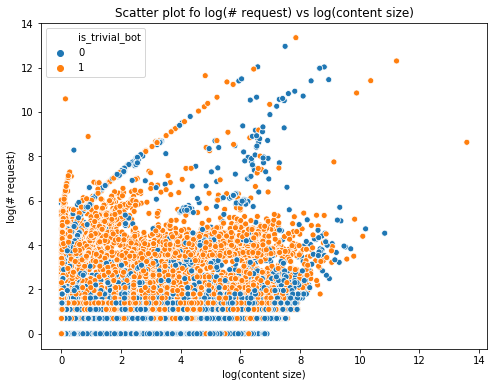

In [163]:
# plot of client aggregated features
plt.figure(figsize=(8,6))
data = clients.toPandas()
sns.scatterplot(data.log_content_size, data.log_n_request,hue=data.is_trivial_bot)
plt.xlabel("log(content size)")
plt.ylabel("log(# request)")
plt.title("Scatter plot fo log(# request) vs log(content size)")
plt.show()

It seems that the extreme points in this 2D space are trivial bots i.e requsting too frquently or/and retrieving consequent amount of data from server.

# To be continued :)